In [1]:
# ------------------------
# Core imports
# ------------------------

import numpy as np
import pandas as pd
from pathlib import Path


In [2]:
# ------------------------
# Import DecisionTreeClassifier from our package
# ------------------------

import sys

# Add src folder to Python path
repo_root = Path().resolve().parents[2]  # moves up to repo root
src_path = repo_root / "src"
sys.path.append(str(src_path))

from rice_ml.supervised_learning.decision_trees import DecisionTreeClassifier


In [3]:
# ------------------------
# Load dataset
# ------------------------

# Build path to dataset (relative to this notebook)
data_path = Path("../../../Data/adult.csv")

df = pd.read_csv(data_path)

df.head()


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [ ]:
# ------------------------
# Quick dataset sanity check
# ------------------------

print(df.shape)
print(df['income'].value_counts()) # (48842, 15)


(48842, 15)
income
<=50K    37155
>50K     11687
Name: count, dtype: int64


In [5]:
# ------------------------
# Step 1: Clean the Adult dataset
# ------------------------

# Replace '?' with NaN so we can handle missing values properly
df = df.replace('?', np.nan)

# Check how many missing values we have now
df.isna().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

In [6]:
# Drop rows with missing values
df = df.dropna()

# Confirm missing values are gone
df.isna().sum()


age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [7]:
# ------------------------
# Step 2: Encode features and prepare X and y
# ------------------------

from sklearn.model_selection import train_test_split

# ------------------------
# Encode target variable
# ------------------------
# income: '<=50K' -> 0, '>50K' -> 1
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

# ------------------------
# One-hot encode categorical features
# ------------------------
categorical_cols = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'gender',
    'native-country'
]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# ------------------------
# Separate features and target
# ------------------------
X = df_encoded.drop(columns=['income']).values
y = df_encoded['income'].values

# ------------------------
# Train-test split
# ------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Check shapes
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (36177, 96) (36177,)
Test set shape: (9045, 96) (9045,)


Decision Tree accuracy on test set: 0.8499

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      6803
        >50K       0.74      0.60      0.67      2242

    accuracy                           0.85      9045
   macro avg       0.81      0.77      0.78      9045
weighted avg       0.84      0.85      0.84      9045



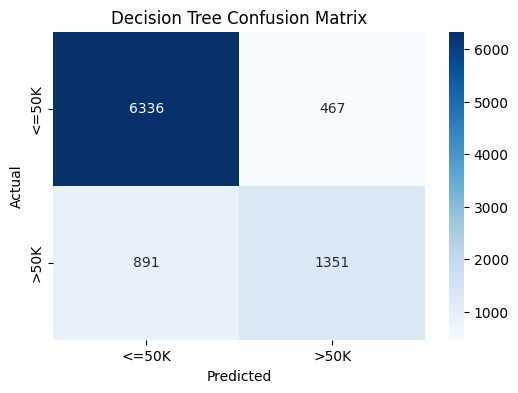

In [8]:
# ------------------------
# Step 3: Train and evaluate the Decision Tree
# ------------------------

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------
# Initialize the Decision Tree
# ------------------------
tree_clf = DecisionTreeClassifier(
    max_depth=10,          # limit depth to prevent overfitting
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

# ------------------------
# Train the model
# ------------------------
tree_clf.fit(X_train, y_train)

# ------------------------
# Make predictions
# ------------------------
y_pred = tree_clf.predict(X_test)

# ------------------------
# Evaluate accuracy
# ------------------------
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree accuracy on test set: {accuracy:.4f}")

# ------------------------
# Classification report
# ------------------------
print("\nClassification Report:")
print(classification_report(y_test, y_pred,
                            target_names=['<=50K', '>50K']))

# ------------------------
# Confusion matrix
# ------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['<=50K', '>50K'],
    yticklabels=['<=50K', '>50K']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()


max_depth = 3, test accuracy = 0.8362
max_depth = 5, test accuracy = 0.8457
max_depth = 7, test accuracy = 0.8503
max_depth = 10, test accuracy = 0.8499
max_depth = 15, test accuracy = 0.8453
max_depth = 20, test accuracy = 0.8321


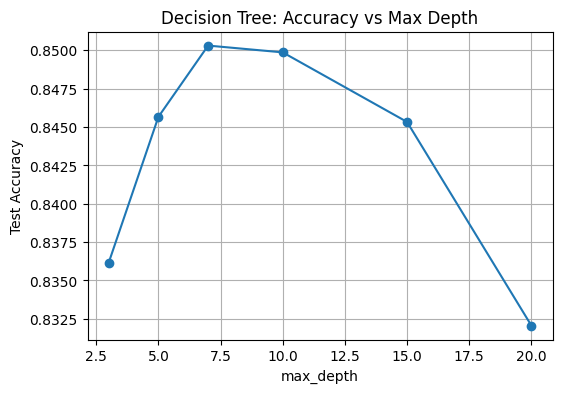

In [9]:
# ------------------------
# Step 4: Tune max_depth and evaluate performance
# ------------------------

depth_range = [3, 5, 7, 10, 15, 20]
results = []

for depth in depth_range:
    clf = DecisionTreeClassifier(
        max_depth=depth,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
    clf.fit(X_train, y_train)
    y_pred_depth = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred_depth)
    results.append((depth, acc))
    print(f"max_depth = {depth}, test accuracy = {acc:.4f}")

# ------------------------
# Plot accuracy vs depth
# ------------------------
depths, accuracies = zip(*results)

plt.figure(figsize=(6,4))
plt.plot(depths, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('Test Accuracy')
plt.title('Decision Tree: Accuracy vs Max Depth')
plt.grid(True)
plt.show()


Decision Tree accuracy on test set (max_depth=7): 0.8503


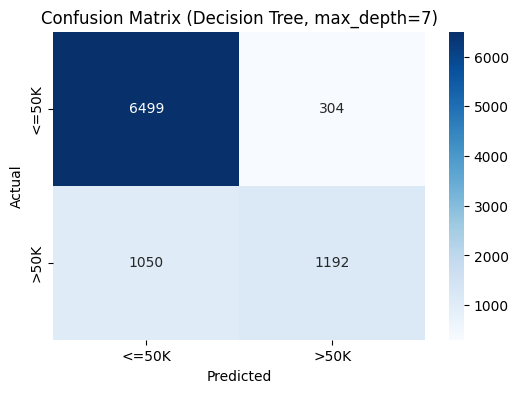


Classification Report:
              precision    recall  f1-score   support

       <=50K       0.86      0.96      0.91      6803
        >50K       0.80      0.53      0.64      2242

    accuracy                           0.85      9045
   macro avg       0.83      0.74      0.77      9045
weighted avg       0.85      0.85      0.84      9045



In [10]:
# ------------------------
# Step 5: Final model evaluation with best max_depth
# ------------------------

best_depth = 7

final_tree = DecisionTreeClassifier(
    max_depth=best_depth,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
final_tree.fit(X_train, y_train)

# Predict on test set
y_final_pred = final_tree.predict(X_test)

# Compute accuracy
final_acc = accuracy_score(y_test, y_final_pred)
print(f"Decision Tree accuracy on test set (max_depth={best_depth}): {final_acc:.4f}")

# ------------------------
# Confusion matrix
# ------------------------
cm_final = confusion_matrix(y_test, y_final_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Decision Tree, max_depth={best_depth})')
plt.show()

# ------------------------
# Classification report
# ------------------------
print("\nClassification Report:")
print(classification_report(y_test, y_final_pred,
                            target_names=['<=50K', '>50K']))


Top 10 features by importance:
capital-loss: 1.2206
capital-gain: 0.6462
fnlwgt: 0.3065
age: 0.2218
educational-num: 0.1497
marital-status_Married-civ-spouse: 0.0746
relationship_Wife: 0.0627
occupation_Prof-specialty: 0.0521
hours-per-week: 0.0498
gender_Male: 0.0367


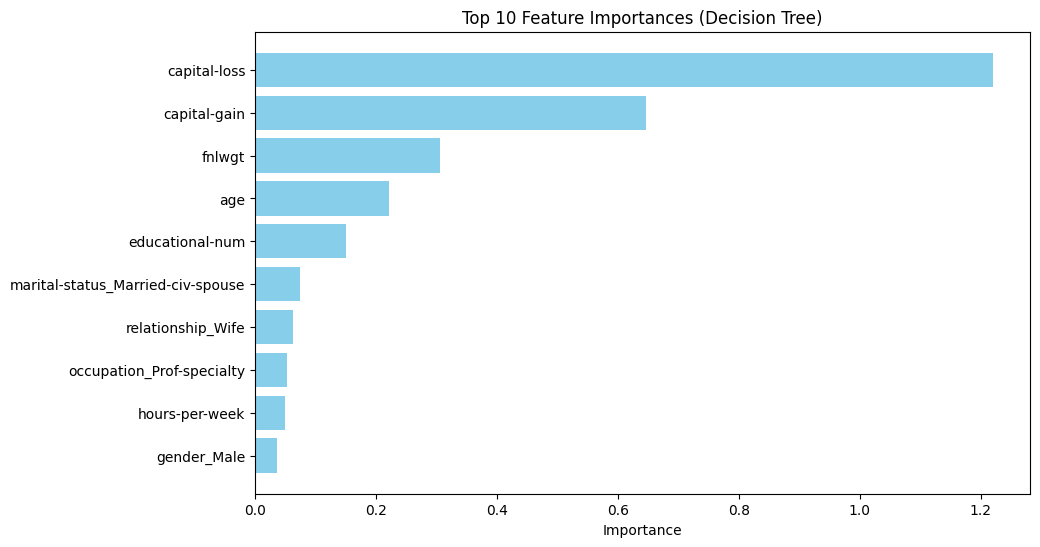

In [18]:
# ------------------------
# Step 6: Feature importance (corrected version)
# ------------------------

import numpy as np
import matplotlib.pyplot as plt
from rice_ml.supervised_learning.decision_trees import DecisionTreeClassifier, _TreeNode

def compute_feature_importance_samples(node: _TreeNode, X: np.ndarray, y: np.ndarray, n_features: int) -> np.ndarray:
    """
    Recursively compute feature importance by weighted Gini decrease.
    
    Parameters
    ----------
    node : _TreeNode
        Current node in the tree
    X : np.ndarray
        Subset of features reaching this node
    y : np.ndarray
        Subset of labels reaching this node
    n_features : int
        Number of features
    
    Returns
    -------
    importances : np.ndarray
        Array of feature importances
    """
    importances = np.zeros(n_features)
    
    # If leaf, return zeros
    if node.is_leaf() or X.shape[0] == 0:
        return importances
    
    # Get left and right masks
    left_mask = X[:, node.feature_index] <= node.threshold
    right_mask = ~left_mask
    
    X_left, y_left = X[left_mask], y[left_mask]
    X_right, y_right = X[right_mask], y[right_mask]
    
    # Compute Gini impurity at this node and children
    def gini(y_subset):
        if y_subset.size == 0:
            return 0.0
        counts = np.bincount(y_subset, minlength=tree.n_classes_)
        p = counts / counts.sum()
        return 1 - np.sum(p ** 2)
    
    n_node = X.shape[0]
    n_left = X_left.shape[0]
    n_right = X_right.shape[0]
    
    gini_parent = gini(y)
    gini_left = gini(y_left)
    gini_right = gini(y_right)
    
    # Weighted Gini decrease
    delta_gini = gini_parent - (n_left / n_node) * gini_left - (n_right / n_node) * gini_right
    importances[node.feature_index] += delta_gini
    
    # Recurse into children
    importances += compute_feature_importance_samples(node.left, X_left, y_left, n_features)
    importances += compute_feature_importance_samples(node.right, X_right, y_right, n_features)
    
    return importances

# Compute feature importances
tree = final_tree  # your fitted DecisionTreeClassifier
n_features = X_train.shape[1]

importances = compute_feature_importance_samples(tree.tree_, X_train, y_train, n_features)

# Map back to column names
feature_names = df_encoded.drop(columns=['income']).columns
feat_imp_dict = dict(zip(feature_names, importances))

# Sort features
sorted_features = sorted(feat_imp_dict.items(), key=lambda x: x[1], reverse=True)

# Top 10 features
print("Top 10 features by importance:")
for feat, imp in sorted_features[:10]:
    print(f"{feat}: {imp:.4f}")

# Plot top 10
top_feats, top_imps = zip(*sorted_features[:10])
plt.figure(figsize=(10,6))
plt.barh(top_feats[::-1], top_imps[::-1], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Decision Tree)')
plt.show()


In [20]:
# ------------------------
# Step 7: Tree Visualization
# ------------------------

def print_tree(node, feature_names, depth=0):
    """Recursively print the decision tree structure."""
    indent = "  " * depth
    if node.is_leaf():
        # Leaf node: print class probabilities
        probs = ", ".join([f"{i}:{p:.2f}" for i, p in enumerate(node.proba)])
        print(f"{indent}Leaf: [{probs}]")
    else:
        feature = feature_names[node.feature_index]
        print(f"{indent}if {feature} <= {node.threshold:.2f}:")
        print_tree(node.left, feature_names, depth + 1)
        print(f"{indent}else:")
        print_tree(node.right, feature_names, depth + 1)

# Get the feature names from the preprocessed dataframe
feature_names = df_encoded.drop(columns=['income']).columns

# Print the tree for the final model
print_tree(final_tree.tree_, feature_names)


if marital-status_Married-civ-spouse <= 0.00:
  if capital-gain <= 6849.00:
    if educational-num <= 13.00:
      if capital-loss <= 2206.00:
        if hours-per-week <= 42.00:
          if age <= 38.00:
            if marital-status_Married-AF-spouse <= 0.00:
              Leaf: [0:0.99, 1:0.01]
            else:
              Leaf: [0:0.69, 1:0.31]
          else:
            if educational-num <= 12.00:
              Leaf: [0:0.97, 1:0.03]
            else:
              Leaf: [0:0.88, 1:0.12]
        else:
          if educational-num <= 12.00:
            if age <= 33.00:
              Leaf: [0:0.97, 1:0.03]
            else:
              Leaf: [0:0.91, 1:0.09]
          else:
            if age <= 27.00:
              Leaf: [0:0.97, 1:0.03]
            else:
              Leaf: [0:0.74, 1:0.26]
      else:
        if capital-loss <= 2339.00:
          if capital-loss <= 2282.00:
            if fnlwgt <= 138107.00:
              Leaf: [0:0.00, 1:1.00]
            else:
        

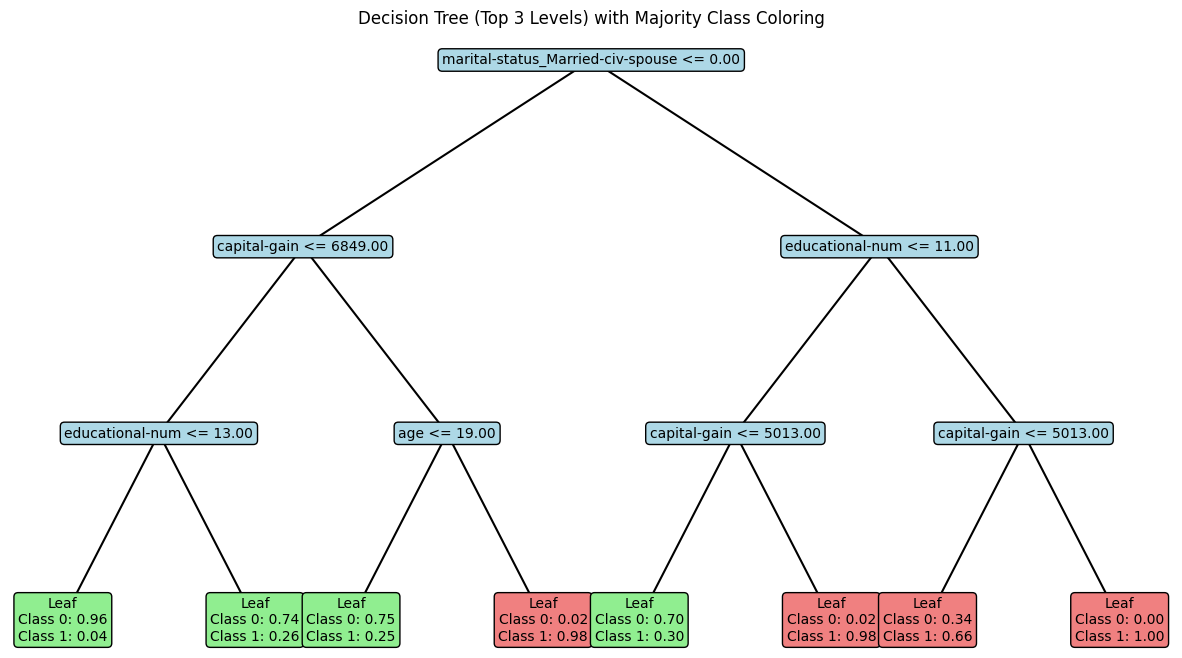

In [25]:
# ------------------------
# Simplified Tree Visualization with Majority Class Coloring (max depth = 3)
# ------------------------
def plot_tree_colored(node, feature_names, max_depth=3, depth=0, pos=(0,0), x_spacing=1.0, y_spacing=1.5, ax=None):
    """
    Recursively plot a simplified decision tree with nodes colored by majority class.
    
    Parameters
    ----------
    node : _TreeNode
        Current tree node
    feature_names : list of str
        Feature names for labeling splits
    max_depth : int
        Maximum levels to display
    depth : int
        Current recursion depth
    pos : tuple(float, float)
        (x, y) position of current node
    x_spacing, y_spacing : float
        Node spacing for layout
    ax : matplotlib.axes.Axes
        Axis to plot on
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))
    
    x, y = pos
    
    # Determine majority class for coloring
    majority_class = np.argmax(node.proba)
    colors = ['lightgreen', 'lightcoral']  # class 0 = lightgreen, class 1 = lightcoral
    
    if node.is_leaf() or depth >= max_depth:
        label = "\n".join([f"Class {i}: {p:.2f}" for i, p in enumerate(node.proba)])
        ax.text(x, y, f"Leaf\n{label}", ha='center', va='center',
                bbox=dict(boxstyle="round", facecolor=colors[majority_class], edgecolor='black'))
    else:
        feature = feature_names[node.feature_index]
        ax.text(x, y, f"{feature} <= {node.threshold:.2f}", ha='center', va='center',
                bbox=dict(boxstyle="round", facecolor='lightblue', edgecolor='black'))
        
        left_pos = (x - x_spacing / (depth+1), y - y_spacing)
        right_pos = (x + x_spacing / (depth+1), y - y_spacing)
        ax.plot([x, left_pos[0]], [y, left_pos[1]], color='k')
        ax.plot([x, right_pos[0]], [y, right_pos[1]], color='k')
        
        plot_tree_colored(node.left, feature_names, max_depth, depth+1, left_pos, x_spacing, y_spacing, ax)
        plot_tree_colored(node.right, feature_names, max_depth, depth+1, right_pos, x_spacing, y_spacing, ax)
    
    if depth == 0:
        ax.axis('off')
        plt.title(f"Decision Tree (Top {max_depth} Levels) with Majority Class Coloring")
        plt.show()

# Plot only top 3 levels for clarity
plot_tree_colored(final_tree.tree_, feature_names, max_depth=3)
